In [13]:

#!pip install plotly
#!pip install pygam
#!pip install lime

future_steps = 24  # Specify how many future steps you want to predict

import numpy as np
import pandas as pd
from pygam import LinearGAM, s
from sklearn.model_selection import KFold
from datetime import datetime
import plotly.graph_objs as go
import plotly.express as px



# Load Data
rates_frame = pd.read_csv('EURUSD_RATES')[:-future_steps]
rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')

# Adding tick_volume - count the number of records (ticks) per time period
rates_frame['tick_volume'] = rates_frame.groupby('time')['time'].transform('count')

# Add hour_only and minute_only columns
rates_frame['hour_only'] = rates_frame['time'].dt.hour
rates_frame['minute_only'] = rates_frame['time'].dt.minute

# Prepare data for GAM
X = rates_frame[['open', 'high', 'low', 'tick_volume', 'hour_only', 'minute_only']]  # Include hour_only and minute_only
y = rates_frame['close']

# Fit GAM model with Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit GAM model
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X_train, y_train)  # Include hour_only and minute_only in model

    # Predict using the GAM model
    predictions = gam.predict(X_test)

    # Calculate and store mean squared error for this fold
    mse = np.mean((predictions - y_test) ** 2)
    cross_val_scores.append(mse)

# Print the cross-validation results
print(f'Mean Squared Error from Cross-Validation: {np.mean(cross_val_scores)}')

# Fit the final model on the entire dataset
final_gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X, y)  # Include hour_only and minute_only in model

# Predict using the final model on the training data
train_predictions = final_gam.predict(X)

# Function to predict future prices
def predict_future_prices(model, last_data, future_steps):
    future_predictions = []
    for _ in range(future_steps):
        next_prediction = model.predict([last_data])
        future_predictions.append(next_prediction[0])

        # Update the last_data with the new prediction
        last_data = np.array([last_data[0], last_data[1], last_data[2], last_data[3], last_data[4], last_data[5]])  # Retain tick_volume, hour_only, minute_only
        last_data[2] = next_prediction  # Update low with predicted close (as an example)

    return future_predictions

# Predicting future prices
last_open = rates_frame['open'].iloc[-1]
last_high = rates_frame['high'].iloc[-1]
last_low = rates_frame['low'].iloc[-1]
last_tick_volume = rates_frame['tick_volume'].iloc[-1]  # Get last tick_volume
last_hour = rates_frame['hour_only'].iloc[-1]  # Get last hour
last_minute = rates_frame['minute_only'].iloc[-1]  # Get last minute
last_data = [last_open, last_high, last_low, last_tick_volume, last_hour, last_minute]

future_predictions = predict_future_prices(final_gam, last_data, future_steps)

# Create future dates for plotting
future_dates = pd.date_range(start=rates_frame['time'].iloc[-1], periods=future_steps + 1, freq='h')[1:]

# Create a DataFrame for future predictions
future_df = pd.DataFrame({
    'time': future_dates,
    'Predicted_Close': future_predictions
})

# Plot results using Plotly
fig = go.Figure()

# Actual Close Prices
fig.add_trace(go.Scatter(x=rates_frame['time'], y=rates_frame['close'], mode='lines', name='Actual Close Prices', line=dict(color='blue', width=2)))

# Training Predictions
fig.add_trace(go.Scatter(x=rates_frame['time'], y=train_predictions, mode='lines', name='Training Predictions', line=dict(color='orange', width=2)))

# Future Predictions
fig.add_trace(go.Scatter(x=future_df['time'], y=future_df['Predicted_Close'], mode='lines', name='Future Predictions', line=dict(color='red', width=2)))

# Update layout
fig.update_layout(title='GAM Model Predictions vs Actual Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
                  hovermode='x unified')

# Show the plot
fig.show()

Mean Squared Error from Cross-Validation: 1.294532079984077e-07


<ipython-input-13-b8005955c1fd>:68: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



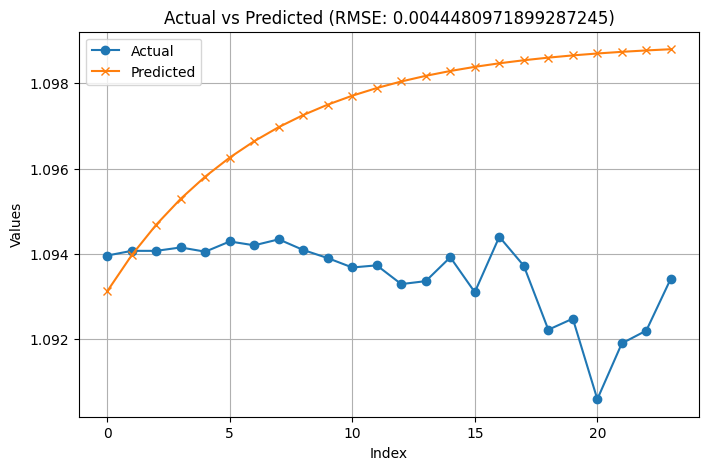

In [14]:
predicted = list(future_df["Predicted_Close"].values)
actual   = list(rates_frame["close"][-future_steps:].values)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.plot(actual, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.title(f'Actual vs Predicted (RMSE: {rmse})')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

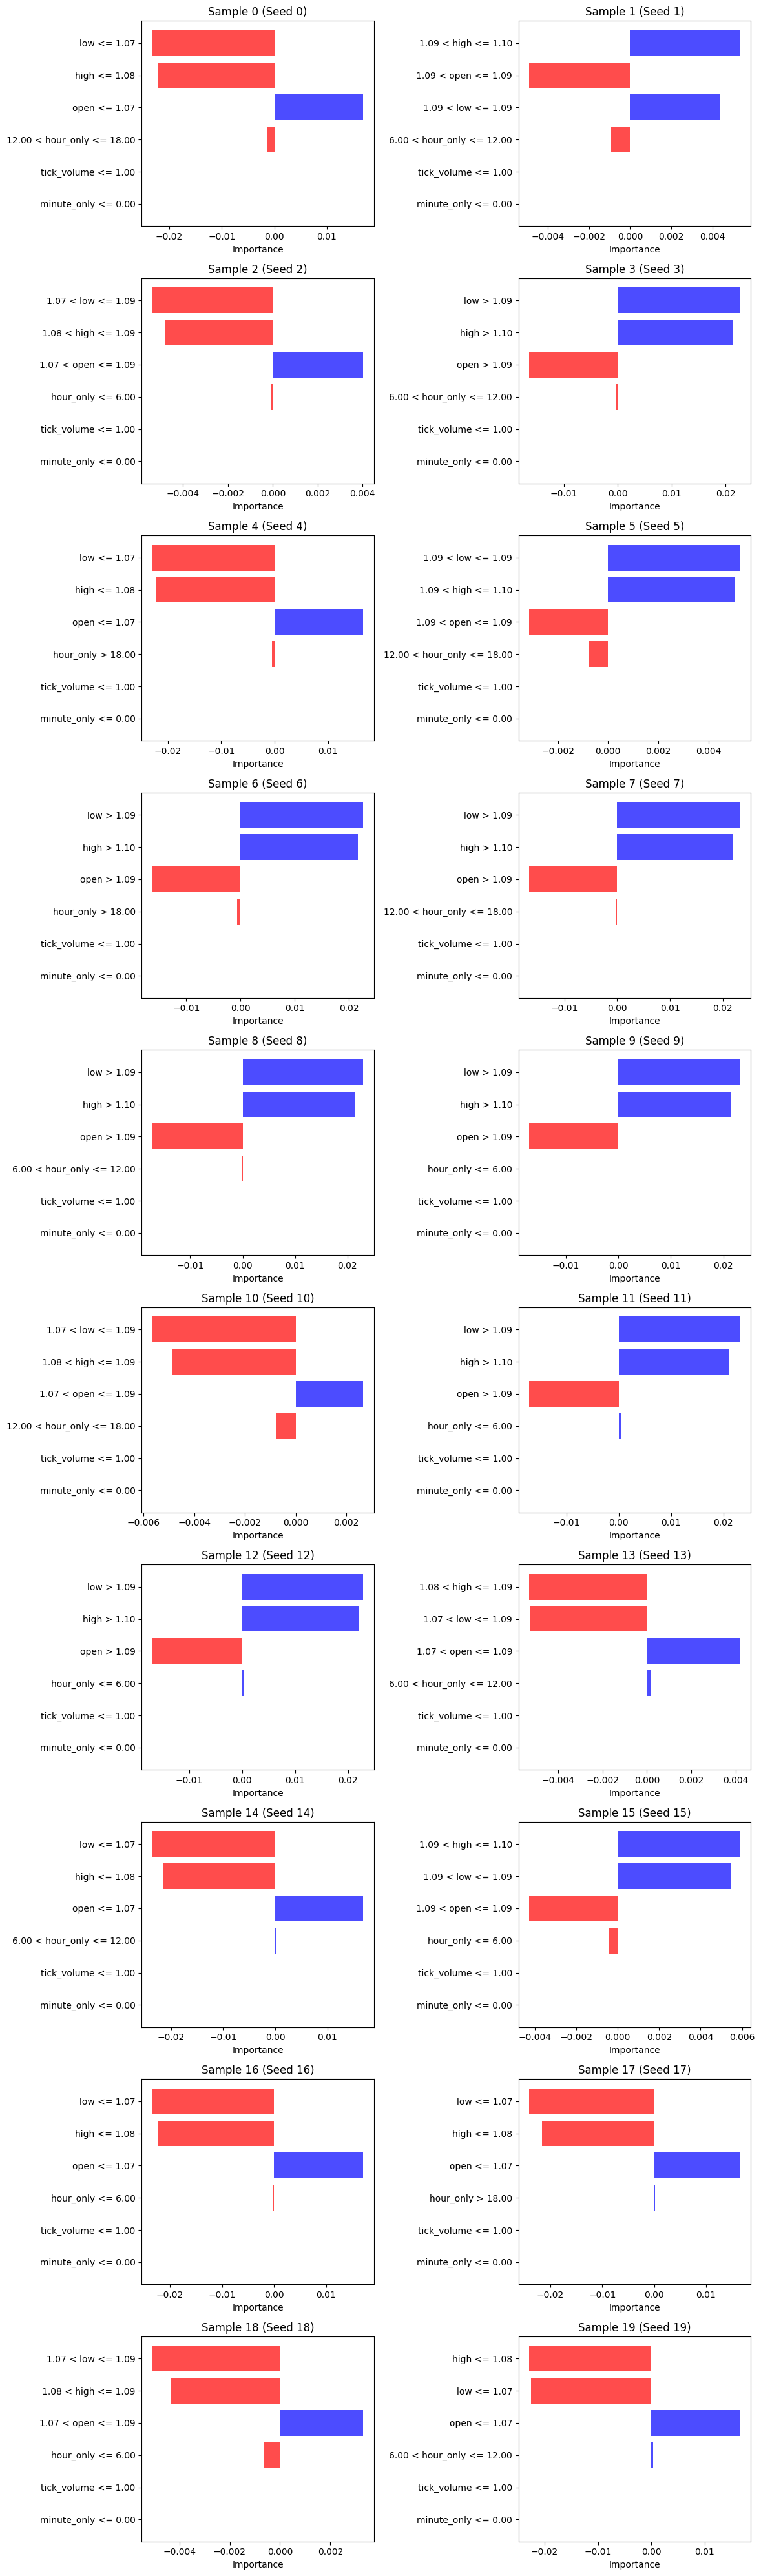

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# Define the number of times to change the random seed
ntimes = 20

# Prepare a DataFrame to aggregate explanations
explanation_data = pd.DataFrame()

# Define the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X.values,  # Use the training data for explainer
    feature_names=X.columns,  # Feature names
    class_names=['Close Price'],  # Target variable name
    mode='regression'  # Regression problem
)

# Create a figure with subplots arranged in a grid (e.g., 2x5 for 10 plots)
fig, axs = plt.subplots(nrows=ntimes // 2, ncols=2, figsize=(12, 4 * (ntimes // 2)))  # Adjust layout to 2 columns
axs = axs.flatten()  # Flatten to easily loop through subplots

# Loop through the number of times to generate explanations
for i in range(ntimes):
    np.random.seed(i)  # Change the random seed
    sample_index = np.random.randint(0, len(X_test))  # Random sample from test set
    sample_data = X_test.iloc[sample_index].values  # Get the feature values of the sample

    # Generate explanation
    explanation = explainer.explain_instance(
        data_row=sample_data,
        predict_fn=final_gam.predict,  # Prediction function
        num_features=6  # Number of features to display
    )

    # Extract feature importances and feature names
    feature_importances = explanation.as_list()

    # Prepare data for plotting
    features, importances = zip(*feature_importances)

    # Convert to DataFrame for easy aggregation
    temp_df = pd.DataFrame({'feature': features, f'importance_seed_{i}': importances})
    explanation_data = pd.merge(explanation_data, temp_df, on='feature', how='outer') if not explanation_data.empty else temp_df

    # Plot the feature importances on the corresponding subplot
    colors = ['blue' if imp >= 0 else 'red' for imp in importances]  # Set color based on importance value
    axs[i].barh(features, importances, alpha=0.7, color=colors)
    axs[i].set_title(f'Sample {i} (Seed {i})')
    axs[i].set_xlabel('Importance')
    axs[i].invert_yaxis()  # Invert y-axis for better readability

# Adjust layout
plt.tight_layout()
plt.show()